In [32]:
import gcs
import h5py
import tstrippy
import numpy as np 
from astropy import units as u
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import sys 
sys.path.append("/obs/sferrone/stream_analysis/stream_analysis/")
import tailCoordinates as TC
sys.path.append("/obs/sferrone/stream_analysis/stream_analysis/plotters/")
import binned_density as bd
from scipy.ndimage import maximum_filter, label, find_objects


In [2]:
def grab_valid_fnames(GCname, montecarlokey, NPs, MASS_INDEX, RADIUS_INDEX, potential_env, internal_dynamics):
    fnames = []
    valid_NPs=[]
    FNAME = "{:s}-StreamSnapShots-{:s}_mass_{:s}_radius_{:s}.hdf5".format(GCname, montecarlokey, str(MASS_INDEX).zfill(3), str(RADIUS_INDEX).zfill(3))
    for i in range(len(NPs)):
        path=gcs.path_handler._StreamSnapShots(GCname=GCname,NP=NPs[i],potential_env=potential_env,internal_dynamics=internal_dynamics)
        fpath=path+FNAME
        if os.path.exists(fpath):
            fnames.append(fpath)
            valid_NPs.append(NPs[i])
        else:
            print("file does not exist",fpath)
    valid_NPs=np.array(valid_NPs)
    return fnames,valid_NPs

In [3]:
def stack_phase_space(fnames,NPs,time_of_interest=0):
    """ assumes all fnames are valid files of the same format 
    """
    # set the indicies
    cummulative_NPs = np.cumsum(NPs)
    cummulative_NPs = np.insert(cummulative_NPs, 0, 0)
    # initiate the output arrays 
    phase_space = np.zeros((6,NPs.sum()))
    tesc=np.zeros(NPs.sum())
    snapshottime=np.zeros(len(fnames))
    for i in range(len(fnames)):
        with h5py.File(fnames[i],"r") as f:
            target_index = np.argmin(np.abs(f['time_stamps'][:]-time_of_interest))
            phase_space[:,cummulative_NPs[i]:cummulative_NPs[i+1]] = f["StreamSnapShots"][str(target_index)][:]
            tesc[cummulative_NPs[i]:cummulative_NPs[i+1]] = f['tesc'][:]
            snapshottime[i]=f['time_stamps'][target_index]
    return phase_space, tesc, snapshottime

In [4]:
# get the position of the GC at the escape time 
def get_position_at_escape(tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,escape_time):
    position_at_escape=np.zeros((6,len(escape_time)))
    indexes_at_escape=np.zeros(len(escape_time))
    for i in range(len(escape_time)):
        indexes_at_escape[i]=np.argmin(np.abs(tGC-escape_time[i]))
    indexes_at_escape=indexes_at_escape.astype(int)
    position_at_escape[0]=xGC[indexes_at_escape]
    position_at_escape[1]=yGC[indexes_at_escape]
    position_at_escape[2]=zGC[indexes_at_escape]
    position_at_escape[3]=vxGC[indexes_at_escape]
    position_at_escape[4]=vyGC[indexes_at_escape]
    position_at_escape[5]=vzGC[indexes_at_escape]
    return position_at_escape

In [40]:
# use this wonderful code from co-pilot for finding the local maxima
def get_peaks(grid):
    # Apply maximum filter
    neighborhood_size = 10
    local_max = maximum_filter(grid, size=neighborhood_size) == grid

    # Label the local maxima
    labeled, num_objects = label(local_max)

    # Extract the coordinates of the local maxima
    slices = find_objects(labeled)
    coordinates = [(int((dy.start + dy.stop - 1) / 2), int((dx.start + dx.stop - 1) / 2)) for dy, dx in slices]

    # sort for the largest maximuma
    massimi = np.zeros(len(coordinates))
    for i,coord in enumerate(coordinates):
        massimi[i] = grid[coord[0],coord[1]]
    sortdexes=np.argsort(massimi)[::-1]
    mycoordinates=[coordinates[i] for i in sortdexes]
    return mycoordinates


## i/o
def build_output_data(coordinates,tau_foob,time_foob,mag_total,GCmags,Perturbers,NKEEPS):
    suspects,tau,time,mag = [],[],[],[]
    for i in range(NKEEPS):
        mags_all = GCmags[:,coordinates[i][0],coordinates[i][1]] - mag_total[coordinates[i][0],coordinates[i][1]]
        suspects.append(str(Perturbers[np.argmin(np.abs(mags_all))].decode('utf-8')))
        tau.append(tau_foob[coordinates[i][1]])
        time.append(time_foob[coordinates[i][0]])
        mag.append(mag_total[coordinates[i][0],coordinates[i][1]])
    return time,tau,mag,suspects

In [6]:
fname="/scratch2/sferrone/simulations/ForceOnOrbit/pouliasis2017pii-GCNBody/Pal5/Pal5-monte-carlo-009.hdf5"
myfile=h5py.File(fname,"r")
myfile.keys()

<KeysViewHDF5 ['Masses', 'Perturbers', 'ax', 'ay', 'az', 'magnitude', 'rs', 'tau', 'tau_indexing', 'time', 'time_indexing']>

In [50]:
tau_foob=myfile['tau'][:]
time_foob=myfile['time'][:]


In [46]:
Perturbers=myfile['Perturbers'][:]

In [42]:
magnitude=myfile['magnitude'][:].sum(axis=0)
GC_alls=myfile['magnitude'][:]
GC_alls.shape

(164, 4868, 265)

In [56]:
NKEEPS=20

In [57]:
coordinates=get_peaks(magnitude)

In [58]:
time,tau,mag,suspects=build_output_data(coordinates,tau_foob,time_foob,magnitude,GC_alls,Perturbers,NKEEPS)

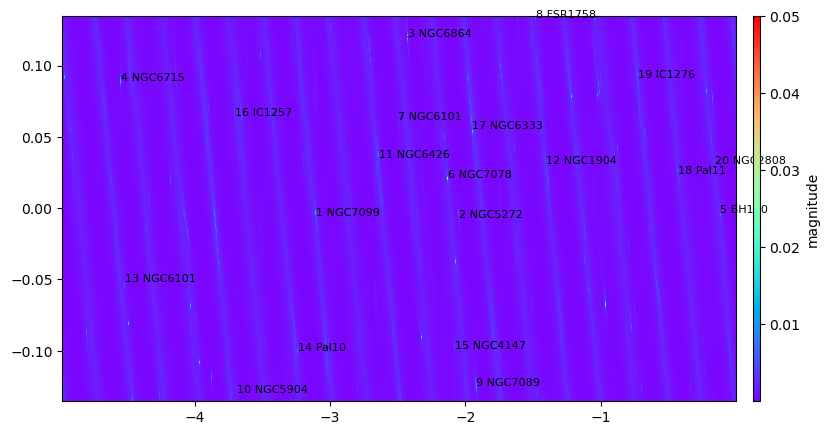

In [59]:
fig=plt.figure(figsize=(9,5))
gs=plt.GridSpec(1,2,width_ratios=[1,1/100],wspace=0.05)
ax1=fig.add_subplot(gs[0])
caxis=fig.add_subplot(gs[1])
cmap=plt.get_cmap('rainbow')
norm=mpl.colors.Normalize(vmin=1e-5,vmax=5e-2)
im=ax1.pcolorfast(myfile['time'][:],myfile['tau'][:],magnitude.T,cmap=cmap,norm=norm)
cbar=plt.colorbar(im,cax=caxis)
cbar.set_label('magnitude')
for i in range(NKEEPS):
    mystring="{:d} {:s}".format(i+1,suspects[i])
    ax1.text(time[i],tau[i],mystring,color='black',fontsize=8)

In [62]:
GCname="Pal5"
NP=int(9400)
potential_env="pouliasis2017pii-GCNBody"
internal_dynamics="isotropic-plummer_mass_radius_grid"
montecarlokey="monte-carlo-009"
Mass=2
radius=4

In [63]:
START=9000
END = 10000
skip = 100
NPs=np.arange(START,END+skip,skip,dtype=int)
NPs=np.concatenate(([int(4500)],NPs,))

In [64]:
SIZE_GRID = 5
N_MASS_SAMPLING = SIZE_GRID
N_RADIUS_SAMPLING = SIZE_GRID # square grid

In [65]:
# plot params
xlims=[-15,15]
ylims=[-1,1]

In [66]:
fnames,valid_NPs=grab_valid_fnames(GCname, montecarlokey, NPs, Mass, radius, potential_env, internal_dynamics)

file does not exist /scratch2/sferrone/simulations/StreamSnapShots/pouliasis2017pii-GCNBody/Pal5/9000/isotropic-plummer_mass_radius_grid/Pal5-StreamSnapShots-monte-carlo-009_mass_002_radius_004.hdf5


In [67]:
myfile=h5py.File(fnames[0],"r")
MASS=myfile.attrs['MASS']
HALF_MASS_RADIUS=myfile.attrs['HALF_MASS_RADIUS']

In [68]:
phase_space, tesc, snapshottime=stack_phase_space(fnames,valid_NPs,time_of_interest=0)

In [69]:
fnameorbit=gcs.path_handler.GC_orbits(potential_env,GCname=GCname)
tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=gcs.extractors.GCOrbits.extract_whole_orbit(fnameorbit,montecarlokey=montecarlokey)
TORB, XORB, YORB, ZORB, VXORB, VYORB, VZORB = TC.filter_orbit_by_dynamical_time(tGC, xGC, yGC, zGC, vxGC, vyGC, vzGC, time_of_interest=0, nDynTimes=2)

In [70]:
time_of_interest = 0
xT,yT,zT,vxT,vyT,vzT,indexes =\
    TC.transform_from_galactico_centric_to_tail_coordinates(\
    phase_space[0], phase_space[1], phase_space[2], phase_space[3], phase_space[4], phase_space[5], 
    TORB, XORB, YORB, ZORB, VXORB, VYORB, VZORB, time_of_interest)

In [71]:
# get only the escaped particles
cond_escape = tesc>tesc.min()
escape_time = tesc[cond_escape]

In [72]:
position_at_escape=get_position_at_escape(tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,escape_time)

In [117]:
filter_time_1 = -5
filter_time_2 = -3
# filter for before and after impact
cond_before = escape_time<filter_time_1
cond_time_middle = (filter_time_1<escape_time) & (escape_time<filter_time_2)
cond_after = escape_time>filter_time_2

In [124]:
# the 2D distribution 
XX,YY,HH=bd.short_cut(int(1e5),xT,yT,xlims,ylims)
XX,YY,HH=bd.order_by_density(XX,YY,HH)
# the 2D distribution before and after impact
XX_before,YY_before,HH_before=bd.short_cut(int(1e5),xT[cond_escape][cond_before],yT[cond_escape][cond_before],xlims,ylims)
XX_before,YY_before,HH_before=bd.order_by_density(XX_before,YY_before,HH_before)
XX_after,YY_after,HH_after=bd.short_cut(int(1e5),xT[cond_escape][cond_after],yT[cond_escape][cond_after],xlims,ylims)
XX_after,YY_after,HH_after=bd.order_by_density(XX_after,YY_after,HH_after)
# add middle time
XX_middle,YY_middle,HH_middle=bd.short_cut(int(1e5),xT[cond_escape][cond_time_middle],yT[cond_escape][cond_time_middle],xlims,ylims)
XX_middle,YY_middle,HH_middle=bd.order_by_density(XX_middle,YY_middle,HH_middle)

In [126]:
# the 1D distribution
bins=np.linspace(xlims[0],xlims[1],int(np.sqrt(len(xT))))
HH1D, bin_edges = np.histogram(xT,bins=bins)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
# get the 1D dist before and after impact
HH1D_before, bin_edges = np.histogram(xT[cond_escape][cond_before],bins=bins)
HH1D_after, bin_edges = np.histogram(xT[cond_escape][cond_after],bins=bins)
HH1D_middle, bin_edges = np.histogram(xT[cond_escape][cond_time_middle],bins=bins)

In [127]:
title=r"{:s} {:s} {:s} $M_\odot$ {:s} pc".format(GCname,montecarlokey,str(int(MASS)),str(int(1000*HALF_MASS_RADIUS)))


In [128]:
label_before = r"$t_{{esc}} <$ {:.1f}".format(filter_time_1)
label_middle = r"{:.1f} $< t_{{esc}} <$ {:.1f}".format(filter_time_1,filter_time_2)
label_after = r"$t_{{esc}} >$ {:.1f}".format(filter_time_2)

In [131]:
SCAT={"norm":mpl.colors.Normalize(vmin=1,vmax=15),"cmap":"jet","s":1}
SCAT1={"norm":mpl.colors.Normalize(vmin=escape_time.min(),vmax=0),"cmap":"twilight_shifted","s":1,"alpha":0.5}
SCAT_DEN={"norm":mpl.colors.LogNorm(vmin=1,vmax=1e2),"cmap":"rainbow","s":1,"alpha":0.5}

AXIS={"ylabel":r"$t_{esc}$ [s $\frac{kpc}{km}$]","xlim":xlims,"ylim":[escape_time.min(),0],"xticks":[],"yticks":[-4,-3,-2,-1,0],"title":title}
AXIS_1D={"xlabel":"x [kpc]","ylabel":"Density","xlim":xlims,"ylim":[0.5,1e3],"yscale":"log","yticks":[1,10,100]}
AXIS_map_tesc={"xlabel":"x' [kpc]","ylabel":"y' [kpc]","xlim":xlims,"ylim":ylims,"yticks":[-0.5,0.5],"yticks":[-0.5,0.5],"yticklabels":[-0.5,0.5]}
AXIS_map_density={"xlabel":"x' [kpc]","ylabel":"y' [kpc]","xlim":xlims,"ylim":ylims,"yticks":[-0.5,0.5],"yticklabels":[-0.5,0.5]}

line_all = {"color":"black","label":"All","linestyle":"-","linewidth":2,"zorder":3}
line_before = {"color":"green","label":label_before,"linestyle":"--","linewidth":2,"zorder":10}
line_after = {"color":"blue","label":label_after,"linestyle":"-.","linewidth":2,"zorder":10}
line_middle = {"color":"red","label":label_middle,"linestyle":"-.","linewidth":2,"zorder":10}
clabel="|z| @ escape [kpc]"

In [130]:
step =3
xticks = np.arange(xlims[0],xlims[1]+step,step)

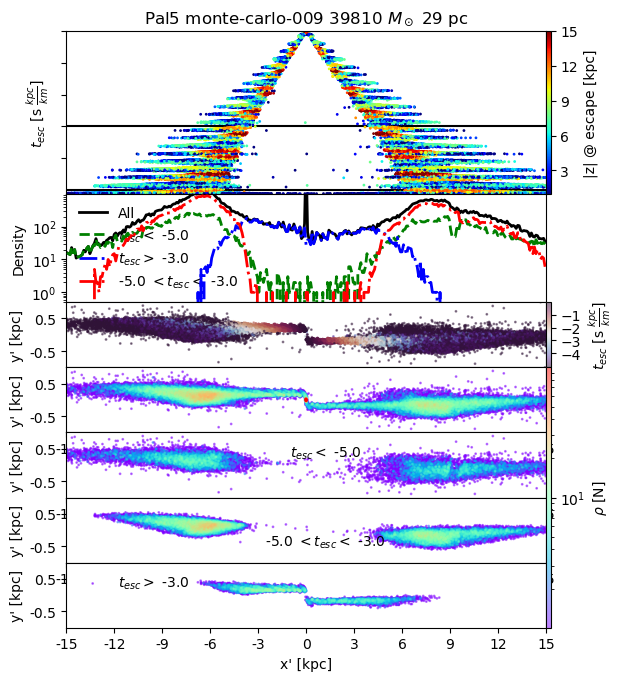

In [137]:
SCAT={"norm":mpl.colors.Normalize(vmin=1,vmax=15),"cmap":"jet","s":1}
SCAT1={"norm":mpl.colors.Normalize(vmin=escape_time.min(),vmax=0),"cmap":"twilight_shifted","s":1,"alpha":0.5}
SCAT_DEN={"norm":mpl.colors.LogNorm(vmin=1,vmax=1e2),"cmap":"rainbow","s":1,"alpha":0.5}




fig=plt.figure(figsize=(8.25-2,11.75-4))
GS=fig.add_gridspec(7,2,height_ratios=[1/2,1/3,1/5,1/5,1/5,1/5,1/5],hspace=0,wspace=0,width_ratios=[1,0.01])
axis=[fig.add_subplot(GS[0]),fig.add_subplot(GS[2]),fig.add_subplot(GS[4]),fig.add_subplot(GS[6]),fig.add_subplot(GS[8]),fig.add_subplot(GS[10]),fig.add_subplot(GS[12])]
caxis=[fig.add_subplot(GS[1]),fig.add_subplot(GS[5]),fig.add_subplot(GS[3:7,1])]

for ax in axis:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

# l'abero di natale
im=axis[0].scatter(xT[cond_escape],tesc[cond_escape],c=np.abs(position_at_escape[2]),**SCAT)
cbar=fig.colorbar(im,ax=axis,cax=caxis[0],ticks=np.arange(0,15+3,3))
axis[0].hlines(filter_time_1,xlims[0],xlims[1],color="k",linestyle="-",zorder=0)
axis[0].hlines(filter_time_2,xlims[0],xlims[1],color="k",linestyle="-",zorder=0)
axis[0].set(**AXIS)
cbar.set_label(clabel)

# the 1D density profile
axis[1].plot(bin_centers,HH1D,**line_all)
axis[1].plot(bin_centers,HH1D_before,**line_before)
axis[1].plot(bin_centers,HH1D_after,**line_after)
axis[1].plot(bin_centers,HH1D_middle,**line_middle)
axis[1].legend(frameon=False)
axis[1].set(**AXIS_1D)

# density map with tesc
im=axis[2].scatter(xT[cond_escape],yT[cond_escape],c=escape_time,**SCAT1)
axis[2].set(**AXIS_map_tesc);
cbar=fig.colorbar(im,ax=axis,cax=caxis[1],ticks=[-4,-3,-2,-1])
cbar.set_label(r"$t_{esc}$ [s $\frac{kpc}{km}$]")

# density map
im=axis[3].scatter(XX,YY,c=HH,**SCAT_DEN)
axis[3].set(**AXIS_map_density)
cbar=fig.colorbar(im,ax=axis,cax=caxis[2],ticks=[1e1,])
cbar.set_label(r"$\rho$ [N]")

# density map before impact
im=axis[4].scatter(XX_before,YY_before,label=label_before,c=HH_before,**SCAT_DEN,)
axis[4].set(**AXIS_map_density)
axis[4].legend(frameon=False)

# density map between
im=axis[5].scatter(XX_middle,YY_middle,label=label_middle,c=HH_middle,**SCAT_DEN)
axis[5].set(**AXIS_map_density)
axis[5].legend(frameon=False)  

AXIS_map_density["xticks"]=xticks
AXIS_map_density['xticklabels']=xticks

# density map after impact
im=axis[6].scatter(XX_after,YY_after,label=label_after,c=HH_after,**SCAT_DEN)
axis[6].set(**AXIS_map_density)
axis[6].legend(frameon=False)
